In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import seaborn as sns
import pickle

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
df_PCA_eigenvec = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Population_stratification/pca.eigenvec',
                    sep =' ', header=None)


In [3]:
df_PCA_eigenval = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Population_stratification/pca.eigenval',
                    sep =' ', header=None)

In [4]:
df_inbre = pd.read_csv('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/Population_stratification/inbreeding_coefficient.ibc',
                    sep ='\t', header=0)


In [5]:
f, ax = plt.subplots(1,2, figsize=(14,7))
PC1_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[0, 0]*100, 2)
PC2_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[1, 0]*100, 2)
PC3_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[2, 0]*100, 2)
PC4_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[3, 0]*100, 2)

ax[0].scatter(df_PCA_eigenvec[2], df_PCA_eigenvec[3] ,marker = 'o', facecolors='none', edgecolor='#b2182b')
ax[0].set_xlabel("Eigenvector 1 ({:.2f} %) ".format(PC1_var), fontsize=12)
ax[0].set_ylabel("Eigenvector 2 ({:.2f} %) ".format(PC2_var), fontsize=12)

ax[1].scatter(df_PCA_eigenvec[4], df_PCA_eigenvec[5] ,marker = 'o', facecolors='none', edgecolor='#67a9cf')
ax[1].set_xlabel("Eigenvector 1 ({:.2f} %) ".format(PC3_var), fontsize=12)
ax[1].set_ylabel("Eigenvector 2 ({:.2f} %) ".format(PC4_var), fontsize=12)
plt.show()

In [6]:
df_inbre

FID                  IID     NOMISS     Fhat1     Fhat2     Fhat3
0       0   20191209_Plate1_1B  4186080.0  0.017269 -0.033037 -0.007884
1       0   20191209_Plate1_1D  4186080.0  0.029184 -0.054946 -0.012881
2       0   20191209_Plate1_1E  4186080.0  0.069839 -0.052300  0.008769
3       0   20191209_Plate1_1F  4186080.0  0.061399 -0.053427  0.003986
4       0   20191209_Plate1_1G  4186080.0  0.127230 -0.153492 -0.013131
...   ...                  ...        ...       ...       ...       ...
5754    0  20201222_Plate2_12B  4186080.0  0.080362 -0.085521 -0.002580
5755    0  20201222_Plate2_12C  4186080.0  0.079892 -0.090483 -0.005295
5756    0  20201222_Plate2_12D  4186080.0  0.076469 -0.085526 -0.004528
5757    0  20201222_Plate2_12E  4186080.0  0.060704 -0.085207 -0.012252
5758    0  20201222_Plate2_12F  4186080.0  0.115064 -0.138685 -0.011810

[5759 rows x 6 columns]

In [7]:
def classify(x):
    if x>0.2:
        return '>0.2'
    else:
        return '<0.2'
df_com = pd.concat((df_PCA_eigenvec[[1,2,3,4,5]].set_index(1), df_inbre.iloc[:, 1:].set_index('IID')),axis=1)
df_com['cat_phat3']=df_com['Fhat3'].apply(lambda x: classify(x))
df_com.columns.values[:4] = list('eigenvector_'+str(i) for i in range(1,5))
df_com

eigenvector_1  eigenvector_2  eigenvector_3  \
20191209_Plate1_1B       -0.013021       0.007070      -0.010540   
20191209_Plate1_1D       -0.014410       0.007938      -0.006790   
20191209_Plate1_1E       -0.015355       0.006581      -0.010345   
20191209_Plate1_1F       -0.014197       0.009798      -0.010974   
20191209_Plate1_1G       -0.011596      -0.024979      -0.005801   
...                            ...            ...            ...   
20201222_Plate2_12B      -0.002981      -0.026050       0.014721   
20201222_Plate2_12C      -0.004405      -0.026621       0.016675   
20201222_Plate2_12D      -0.003060      -0.026914       0.017514   
20201222_Plate2_12E      -0.006172      -0.027786       0.015667   
20201222_Plate2_12F      -0.005263      -0.027412       0.015694   

                     eigenvector_4     NOMISS     Fhat1     Fhat2     Fhat3  \
20191209_Plate1_1B        0.002830  4186080.0  0.017269 -0.033037 -0.007884   
20191209_Plate1_1D        0.005967  4186080.0  0.029184 -0.054946 -0.012881   
20191209_Plate1_1E        0.003790  4186080.0  0.069839 -0.052300  0.008769   
20191209_Plate1_1F        0.005250  4186080.0  0.061399 -0.053427  0.003986   
20191209_Plate1_1G       -0.006410  4186080.0  0.127230 -0.153492 -0.013131   
...                            ...        ...       ...       ...       ...   
20201222_Plate2_12B       0.004163  4186080.0  0.080362 -0.085521 -0.002580   
20201222_Plate2_12C       0.006605  4186080.0  0.079892 -0.090483 -0.005295   
20201222_Plate2_12D       0.005074  4186080.0  0.076469 -0.085526 -0.004528   
20201222_Plate2_12E       0.005928  4186080.0  0.060704 -0.085207 -0.012252   
20201222_Plate2_12F       0.005876  4186080.0  0.115064 -0.138685 -0.011810   

                    cat_phat3  
20191209_Plate1_1B       <0.2  
20191209_Plate1_1D       <0.2  
20191209_Plate1_1E       <0.2  
20191209_Plate1_1F       <0.2  
20191209_Plate1_1G       <0.2  
...                       ...  
20201222_Plate2_12B      <0.2  
20201222_Plate2_12C      <0.2  
20201222_Plate2_12D      <0.2  
20201222_Plate2_12E      <0.2  
20201222_Plate2_12F      <0.2  

[5759 rows x 9 columns]

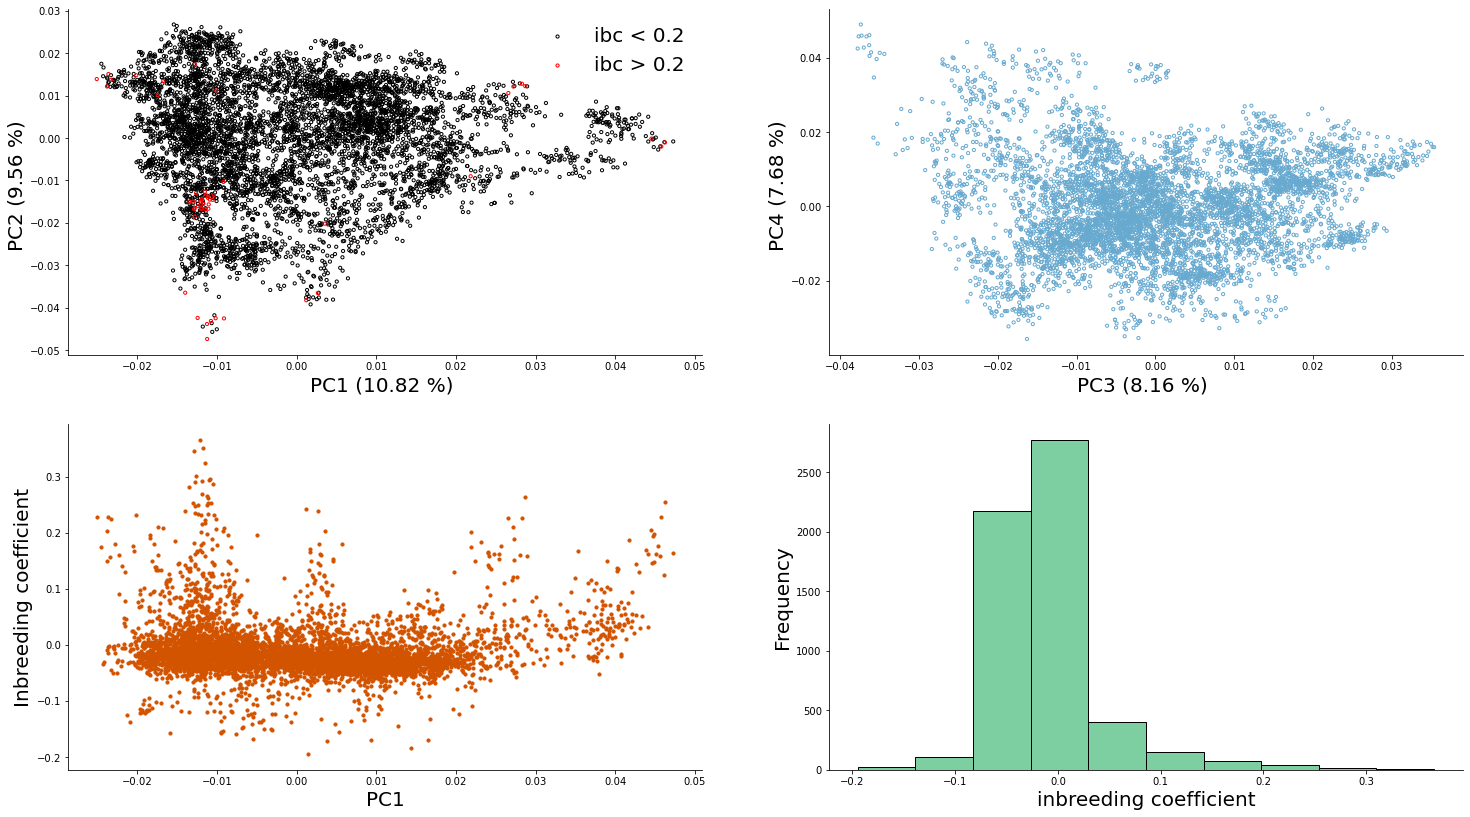

In [20]:
PC1_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[0, 0]*100, 2)
PC2_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[1, 0]*100, 2)
PC3_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[2, 0]*100, 2)
PC4_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[3, 0]*100, 2)

f, ax = plt.subplots(2,2, figsize=(25,14))
for i in range(0,2):
    for j in range(0,2):
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
ax[0][0].scatter(x=df_com.loc[df_com['cat_phat3']=='<0.2']['eigenvector_1'], y=df_com.loc[df_com['cat_phat3']=='<0.2']['eigenvector_2'], 
              edgecolor = 'black', facecolors='none', label='ibc < 0.2', s=10)
ax[0][0].scatter(x=df_com.loc[df_com['cat_phat3']=='>0.2']['eigenvector_1'], y=df_com.loc[df_com['cat_phat3']=='>0.2']['eigenvector_2'], 
              edgecolor = 'r', facecolors='none', label='ibc > 0.2', s=10)
ax[0][0].set_xlabel("PC1 ({:.2f} %) ".format(PC1_var), fontsize=20)
ax[0][0].set_ylabel("PC2 ({:.2f} %) ".format(PC2_var), fontsize=20)
ax[0][0].legend(edgecolor='none', fontsize=20)

ax[0][1].scatter(df_com['eigenvector_3'], df_com['eigenvector_4'] ,marker = 'o', facecolors='none', edgecolor='#67a9cf', s=10)
ax[0][1].set_xlabel("PC3 ({:.2f} %) ".format(PC3_var), fontsize=20)
ax[0][1].set_ylabel("PC4 ({:.2f} %) ".format(PC4_var), fontsize=20)

ax[1][0].scatter(x=df_com['eigenvector_1'], y=df_com['Fhat3'], facecolors='#D35400', s=10)
ax[1][0].set_xlabel("PC1", fontsize=20)
ax[1][0].set_ylabel("Inbreeding coefficient", fontsize=20)

ax[1][1].hist(df_com['Fhat3'], edgecolor='black',facecolor='#7DCEA0')
ax[1][1].set_xlabel('inbreeding coefficient', fontsize=20)
ax[1][1].set_ylabel("Frequency", fontsize=20)
plt.show()

In [42]:
from matplotlib.ticker import FormatStrFormatter
PC1_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[0, 0]*100, 2)
PC2_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[1, 0]*100, 2)
PC3_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[2, 0]*100, 2)
PC4_var = round((df_PCA_eigenval/df_PCA_eigenval.iloc[:20, :].sum()).iloc[3, 0]*100, 2)
f, ax = plt.subplots(1,4, figsize=(24,6))
plt.subplots_adjust(wspace=0.5)
for i in range(0,4):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
ax[0].scatter(x=df_com.loc[df_com['cat_phat3']=='<0.2']['eigenvector_1'], y=df_com.loc[df_com['cat_phat3']=='<0.2']['eigenvector_2'], 
              edgecolor = 'black', facecolors='none', label='ibc < 0.2', s=10)
ax[0].scatter(x=df_com.loc[df_com['cat_phat3']=='>0.2']['eigenvector_1'], y=df_com.loc[df_com['cat_phat3']=='>0.2']['eigenvector_2'], 
              edgecolor = 'r', facecolors='none', label='ibc > 0.2', s=22)
#ax[0][0].set_xlabel("PC1 ({:.2f} %) ".format(PC1_var), fontsize=20)
#ax[0][0].set_ylabel("PC2 ({:.2f} %) ".format(PC2_var), fontsize=20)
ax[0].legend(edgecolor='none', fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=20)

ax[1].scatter(df_com['eigenvector_3'], df_com['eigenvector_4'] ,marker = 'o', facecolors='none', edgecolor='#67a9cf', s=10)
#ax[0][1].set_xlabel("PC3 ({:.2f} %) ".format(PC3_var), fontsize=20)
#ax[0][1].set_ylabel("PC4 ({:.2f} %) ".format(PC4_var), fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[2].scatter(x=df_com['eigenvector_1'], y=df_com['Fhat3'], facecolors='#D35400', s=10)
#ax[1][0].set_xlabel("PC1", fontsize=20)
#ax[1][0].set_ylabel("Inbreeding coefficient", fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=20)

ax[3].hist(df_com['Fhat3'], edgecolor='black',facecolor='#7DCEA0')
#ax[1][1].set_xlabel('inbreeding coefficient', fontsize=20)
#ax[1][1].set_ylabel("Frequency", fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)
plt.show()